In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('C:/Users/luizf/Desktop/MINDS/Datasets/HomeC.csv', sep=',')
data = data.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
#data = data.loc[0: : 10]
X=data.copy()
X.drop(data.tail(2).index,inplace=True)
X
y=data.copy()
y.loc[max(y.index)+1, :] = None
y=y.shift(-1)
y.dropna(inplace=True)
y

C:\Users\luizf\miniconda3\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
1,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
2,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
3,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
4,1.391867,0.003433,0.000283,0.503250,0.063667,0.447033,0.122300,0.006717,0.012433,0.000483,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503904,1.601233,0.003183,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503905,1.599333,0.003233,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503906,1.924267,0.003217,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503907,1.978200,0.003217,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train, X_test = train_test_split(X, test_size=0.25, shuffle=False)
X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=32)

y_train, y_test = train_test_split(y, test_size=0.25, shuffle=False)
y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
y_train = scaler.fit_transform(y_train.values)
y_val = scaler.fit_transform(y_val.values)

if torch.cuda.is_available():
    y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
    y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
else:
    y_train_t = torch.tensor(y_train.astype(np.float32))
    y_val_t = torch.tensor(y_val.astype(np.float32))


In [4]:
#lr decay

#batch norm
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim,nonlinearity='tanh', batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [20]:
def train_rnn(X_train, layer_dim, dropout_prob, epochs, batch_size, learning_rate, step_wdecay, gamma_wdecay, X_val=0):
    train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=batch_size, shuffle=False)
    #val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=batch_size,shuffle=False)
    if torch.cuda.is_available():
        y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
        #y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
    else:
        y_train_t = torch.tensor(y_train.astype(np.float32))
        #y_val_t = torch.tensor(y_val.astype(np.float32))
    torch.manual_seed(1)
    alpha = 0.5
    h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
    model = RNNModel(X_train.shape[1],h, layer_dim,X_train.shape[1],dropout_prob)
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        model = model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    buffer = 10000
    steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_wdecay, gamma=gamma_wdecay)

    min_valid_loss=500
    for epoch in range(epochs):
        aux,aux2=0,0
        train_loss=0.0
        model.train()
        for batch, d in enumerate(train_loader):
            if torch.cuda.is_available():
                d =d.cuda()
            optimizer.zero_grad()  #set gradient to 0
            output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
            if torch.cuda.is_available():
                loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
            else:
                loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
            loss.backward()  #differentiate loss with respect to parameters
            optimizer.step() #apply the method step and updates the parameters 
            train_loss += loss.item()
            aux+=d.shape[0]
        steplr.step()

        #valid_loss = 0.0
        #model.eval() 
        #for dv in val_loader:  
        #    if torch.cuda.is_available():
        #        dv =dv.cuda()  
        #    target = model(dv.unsqueeze(1))
        #    if torch.cuda.is_available():
        #        val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        #    else:
        #        val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        #    valid_loss += val_loss.item()
        #    aux2+=dv.shape[0]
        #print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        #if valid_loss < buffer:
        #    buffer = valid_loss
#
   # print (buffer/len(val_loader))   
    return model

In [21]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [23]:
n_windows = 30
w = round(len(X)/n_windows)
buffer =  {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse":[],
         "variable":[]
    }
    
col = ["window","rmse","mape","mae","r2","variable"]
result = pd.DataFrame(columns=col)
a={}
for i in range(n_windows):
    dfx=X.iloc[int(w*i):int(w*(i+1)), :]
    dfy=y.iloc[int(w*i):int(w*(i+1)), :]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train, X_test = train_test_split(dfx, test_size=0.25, shuffle=False)
    #X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
    X_train = scaler.fit_transform(X_train.values)
    #X_val = scaler.fit_transform(X_val.values)


    y_train, y_test = train_test_split(dfy, test_size=0.25, shuffle=False)
    #y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
    y_train = scaler.fit_transform(y_train.values)
    #y_val = scaler.fit_transform(y_val.values)

    model = train_rnn(X_train, layer_dim=1, dropout_prob=0, epochs=200, batch_size=64, learning_rate=0.001, step_wdecay=30, gamma_wdecay=0.6)

    model.eval()
    if torch.cuda.is_available():
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
    else:
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
    y_norm = scaler.fit_transform(y_test.values)
    #yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
    yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().cpu().numpy())
    #y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]
    
    from pyFTS.benchmarks import Measures
    buffer['rmse']=[Measures.rmse(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mape']=[Measures.mape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mae']=[mean_absolute_error(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['r2']=[r2_score(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['smape']=[Measures.smape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['nrmse']=[cal_nrmse(Measures.rmse(y_test.values[:,j],yhat[:,j]),y_test.values[:,j]) for j in range (X.shape[1])]
    buffer['variable']=[j for j in X.columns]
    buffer['window']= w*i

    result = pd.concat([result, pd.DataFrame(buffer)], ignore_index=True)
    #result['rmse'].append([j for j in buffer['rmse']])
    #result['mape'].append(buffer['mape'])
    #result['mae'].append(buffer['mae'])
    #result['r2'].append(buffer['r2'])
    #result['variable'].append([j for j in X.columns])
    #result['window'].append(buffer['window'])
#
#result = np.mean(buffer)
#print (result)


    
    


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\M

In [24]:
result

,window,rmse,mape,mae,r2,variable,smape,nrmse
0,0,0.312425,16.455355,0.170467,0.800492,use [kW],7.940787,0.068988
1,0,0.028266,inf,0.008658,0.864436,gen [kW],23.706666,0.052892
2,0,0.067464,inf,0.012861,0.909483,Dishwasher [kW],89.817969,0.049322
3,0,0.089206,87.701787,0.049182,0.815477,Furnace 1 [kW],22.163462,0.058386
4,0,0.110547,39.862959,0.056801,0.777021,Furnace 2 [kW],14.554525,0.165874
...,...,...,...,...,...,...,...,...
805,487113,0.285408,2.875452,0.137467,0.993988,windSpeed,1.365139,0.019643
806,487113,7.641297,3.797357,4.242129,0.990549,windBearing,1.598470,0.022474
807,487113,0.000578,inf,0.000179,0.996797,precipIntensity,72.213510,0.012387
808,487113,0.876646,3.017309,0.724369,0.950473,dewPoint,1.499667,0.064649


In [25]:
final_measures = {'variable':[], 'rmse': [], 'mae': [], 'mape': [], 'r2': [], 'smape':[], 'nrmse':[], 'rmse_std': [], 'mae_std': [], 'mape_std': [], 'r2_std': [], 'smape_std':[], 'nrmse_std':[]}
m=[]
for i in list(X.columns):
    m=result[result.variable==i].mean()
    st = result[result.variable==i].std()
    final_measures['variable'].append(i)
    final_measures['rmse'].append(m['rmse'])
    final_measures['mae'].append(m['mae'])
    final_measures['mape'].append(m['mape'])
    final_measures['r2'].append(m['r2'])
    final_measures['smape'].append(m['smape'])
    final_measures['nrmse'].append(m['nrmse'])
    final_measures['rmse_std'].append(st['rmse'])
    final_measures['mae_std'].append(st['mae'])
    final_measures['mape_std'].append(st['mape'])
    final_measures['r2_std'].append(st['r2'])
    final_measures['smape_std'].append(st['smape'])
    final_measures['nrmse_std'].append(st['nrmse'])
pd.DataFrame(final_measures)

C:\Users\luizf\AppData\Local\Temp/ipykernel_22260/2831257117.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m=result[result.variable==i].mean()
C:\Users\luizf\AppData\Local\Temp/ipykernel_22260/2831257117.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  st = result[result.variable==i].std()


,variable,rmse,mae,mape,r2,smape,nrmse,rmse_std,mae_std,mape_std,r2_std,smape_std,nrmse_std
0,use [kW],0.377322,0.192857,89.125252,0.604269,15.567769,0.057194,0.205805,0.127085,125.328158,0.681247,16.358094,0.021201
1,gen [kW],0.021641,0.009493,inf,0.955108,24.290342,0.044863,0.009736,0.006334,NaN,0.036121,11.046064,0.018697
2,Dishwasher [kW],0.052675,0.010715,inf,0.847234,92.291015,0.046043,0.014329,0.003783,NaN,0.364080,2.611244,0.034737
3,Furnace 1 [kW],0.057455,0.023271,39.553966,0.789609,13.409985,0.070926,0.027517,0.017600,26.594497,0.135175,7.138693,0.044097
4,Furnace 2 [kW],0.061490,0.032246,26.973139,0.796098,10.432466,0.102856,0.043668,0.025829,23.389007,0.104227,7.877371,0.053806
5,Home office [kW],0.013945,0.003881,5.157708,0.916648,2.517272,0.026377,0.005181,0.001607,2.176140,0.238233,1.143400,0.007499
6,Fridge [kW],0.022336,0.007796,59.648549,0.911744,17.624741,0.038965,0.003030,0.002482,27.903186,0.013336,6.264210,0.013381
7,Wine cellar [kW],0.008840,0.002580,13.927244,0.969521,5.548846,0.043956,0.006117,0.002082,15.280068,0.024084,5.429276,0.017370
8,Garage door [kW],0.011128,0.003033,18.227451,0.173981,7.164432,0.040208,0.009453,0.004061,30.624799,0.319774,8.050973,0.028964
9,Kitchen 12 [kW],0.004698,0.001133,inf,0.100104,29.020415,0.050817,0.008364,0.001837,NaN,1.017111,26.571385,0.035235


In [26]:
pd.DataFrame(final_measures).to_csv('rnn_kaggle_result.csv')

In [5]:
torch.manual_seed(1)
alpha = 2
h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
model = RNNModel(X_train.shape[1],50, 2,X_train.shape[1],0.0)
if torch.cuda.is_available():
    model = model.cuda()
else:
    model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)
buffer = 10000
steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 30

if torch.cuda.is_available():
    y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
    y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
else:
    y_train_t = torch.tensor(y_train.astype(np.float32))
    y_val_t = torch.tensor(y_val.astype(np.float32))

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d=d.cuda()

        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]
    steplr.step()
    valid_loss = 0.0
    model.eval() 
    for dv in val_loader:    
        target = model(dv.unsqueeze(1).cuda())
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

Epoch 1 		 Training Loss: 0.013093150532257139 		 Validation Loss: 0.017623979671533858
Epoch 2 		 Training Loss: 0.0071747619630300455 		 Validation Loss: 0.013245633167601871
Epoch 3 		 Training Loss: 0.006410383092136534 		 Validation Loss: 0.011478310371121245
Epoch 4 		 Training Loss: 0.006228608916830402 		 Validation Loss: 0.010874870133826906
Epoch 5 		 Training Loss: 0.006171651674396047 		 Validation Loss: 0.010481583584999938
Epoch 6 		 Training Loss: 0.0060956482335473355 		 Validation Loss: 0.01008457694009072
Epoch 7 		 Training Loss: 0.0062788960701773 		 Validation Loss: 0.010288335879992568
Epoch 8 		 Training Loss: 0.006027431564047966 		 Validation Loss: 0.009876651408182184
Epoch 9 		 Training Loss: 0.005984325470406083 		 Validation Loss: 0.009877480108688554
Epoch 10 		 Training Loss: 0.006074924669490544 		 Validation Loss: 0.009867322383961232
Epoch 11 		 Training Loss: 0.006214761880258436 		 Validation Loss: 0.009946036968756927
Epoch 12 		 Training Loss: 0.00

In [6]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.0666765893265674


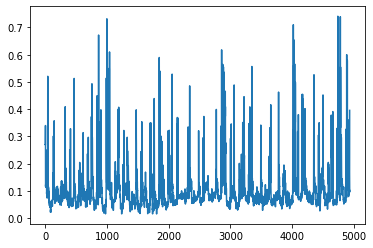

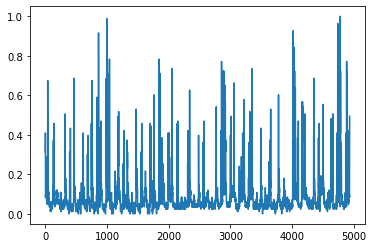

In [54]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])